g_crypto_currency_regression_train_lstm
----

In [1]:
!pip install wandb
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import sys
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from types import SimpleNamespace
from matplotlib import pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 120.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 236.9 MB/s eta 0:00:00
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
BASE_PATH = str(Path.cwd().resolve())
sys.path.append(BASE_PATH)
print(BASE_PATH) 

/home/work/DL/homework4


In [3]:
CURRENT_FILE_PATH = "/home/work/DL/homework4"
print(CURRENT_FILE_PATH)
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
print(CHECKPOINT_FILE_PATH)

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

/home/work/DL/homework4
/home/work/DL/homework4/checkpoints


In [4]:
#from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer

#조기 종료 클래스
#val이 감소하지 않으면 학습을 중단
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience # 조기 종료를 위한 최대 허용 epoch 수
    self.counter = 0 # val의 횟수
    self.delta = delta # val의 최소 개선 폭

    self.val_loss_min = None # 최소 검증 손실 초기화
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  # val을 확인하고 필요 시 모델 저장 및 학습 조기 종료 여부 결정하는 함수
  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None: # 첫 번째 에포크의 경우
      self.val_loss_min = new_validation_loss # 초기 손실 설정
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0# 카운터 초기화
    else:# val이 delta 값 이상 줄지 않는 경우임
      self.counter += 1 # 카운터 증가
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:# 카운터가 patience를 초과한 경우
        early_stop = True# 조기 종료 플래그 설정
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  # val 감소 시 모델을 체크포인트 파일로 저장
  # val_loss 현재 검증 손실 값
# pytorch 모델 객체로 저장
  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    print(f"Saving model checkpoint to: {self.file_path}")
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss

In [5]:
#값을 예쁘게 뽑아주는 템플릿들
def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()

from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)


def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )

In [6]:
class RegressionTrainer:
    # 회귀 모델 학습을 위한 trainer
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
        run_time_str, wandb, device, checkpoint_file_path
    ):
        # 초기화 함수
        self.project_name = project_name 
        self.model = model  # 학습할 모델
        self.optimizer = optimizer  # 최적화 함수
        self.train_data_loader = train_data_loader  # 학습 데이터 load
        self.validation_data_loader = validation_data_loader  # val 데이터 로더
        self.transforms = transforms  # 데이터 변환 함수
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device  # 학습에 사용할 디바이스
        self.checkpoint_file_path = checkpoint_file_path

        # 손실 함수로 MSE(Mean Squared Error) 사용
        self.loss_fn = nn.MSELoss()

    def do_train(self):
        # 모델 학습 함수
        self.model.train()  # 학습 모드로 설정!!

        loss_train = 0.0  # 학습 손실 초기화
        num_trains = 0  # 학습 배치 수 초기화

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch  # 입력과 타겟 데이터를 가져옴
            input_train = input_train.to(device=self.device)  # 입력 데이터를 디바이스로 이동
            target_train = target_train.to(device=self.device)  # 타겟 데이터를 디바이스로 이동

            if self.transforms:
                input_train = self.transforms(input_train)  # 변환 함수가 있으면 적용

            output_train = self.model(input_train)

            loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)  # 손실 계산

            loss_train += loss.item()  # 배치 손실을 누적
            num_trains += 1  # 배치 카운트 증가

            self.optimizer.zero_grad()  # 옵티마이저 초기화 이거 없으면 누적됨
            loss.backward()  # 그라디언트
            self.optimizer.step()  # 업데이트

        train_loss = loss_train / num_trains  # 평균 학습 손실 계산

        return train_loss  # 학습 손실 반환

    def do_validation(self):
        # 모델 검증 함수
        self.model.eval()  # 평가 모드로 설정

        loss_validation = 0.0  # 검증 손실 초기화
        num_validations = 0  # 검증 배치 수 초기화

        with torch.no_grad():  # 검증 단계에서는 grad 비활성화
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch  # 입력과 타겟 데이터 가져옴
                input_validation = input_validation.to(device=self.device)  # 입력 데이터를 hpu로 이동
                target_validation = target_validation.to(device=self.device)  # 타겟 데이터를 gpu로 이동

                if self.transforms:
                    input_validation = self.transforms(input_validation)  # 변환 함수 적용

                output_validation = self.model(input_validation)  # 모델 출력 계산

                loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()  # 손실 계산
                num_validations += 1  # 배치 카운트 증가

        validation_loss = loss_validation / num_validations  # 평균 val 계산

        return validation_loss  # 검증 손실 반환

    def train_loop(self):
        # 학습 루프 함수
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str 
        )
        n_epochs = self.wandb.config.epochs  # 총 학습 에포크 수
        training_start_time = datetime.now()  # 학습 시작 시간 기록

        for epoch in range(1, n_epochs + 1):
            train_loss = self.do_train()  # 학습 수행 및 손실 반환

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:  # 지정된 간격으로 검증 수행
                validation_loss = self.do_validation()  # 검증 수행 및 손실 반환

                elapsed_time = datetime.now() - training_start_time  # 경과 시간 계산
                epoch_per_second = 1000 * epoch / elapsed_time.microseconds  # 에포크 속도 계산

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)  # 조기 종료 확인 및 모델 저장

                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "  # train loss 출력
                    f"V_loss: {validation_loss:7.5f}, "  # val 출력
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "  # 경과 시간 출력
                    f"T_speed: {epoch_per_second:4.3f}"  # 학습 속도 출력
                )

                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Validation loss": validation_loss,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })

                if early_stop:  # 조기 종료 조건 만족 시 중단
                    break

        elapsed_time = datetime.now() - training_start_time  # 총 학습 시간 계산
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")  # 총 학습 시간 출력


In [7]:
class CryptoCurrencyDataset(Dataset):
    # 암호화폐 데이터를 PyTorch Dataset 변환
    def __init__(self, X, y, is_regression=True):
        self.X = X  # 입력 데이터
        self.y = y  # 타겟 데이터

        # 데이터 크기 검증
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # 데이터셋에서 특정 인덱스의 아이템 반환
        X = self.X[idx]
        y = self.y[idx]
        return X, y

    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
            len(self.X), self.X.shape, self.y.shape
        )
        return str


def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    # 데이터를 처리하여 학습, 검증, 테스트 데이터셋 생성
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")  # CSV 파일 경로 설정
    df = pd.read_csv(btc_krw_path)  # CSV 파일 읽기
    row_size = len(df)
    date_list = df['Date']  # 날짜 열 추출

    df = df.drop(columns=['Date'])  # 날짜 열 제거

    data_size = row_size - sequence_size  # 전체 데이터 크기 계산
    train_size = data_size - (validation_size + test_size)  # 학습 데이터 크기 계산

    #################################################################################################
    # 학습 데이터 처리
    row_cursor = 0

    X_train_list = []  # 학습 입력 데이터 리스트
    y_train_regression_list = []  # regression label, 타겟 데이터 리스트
    y_train_classification_list = []  # 학습 분류 타겟 데이터 리스트
    y_train_date = []  # 학습 데이터 날짜 리스트

    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # 입력 데이터 시퀀스
        X_train_list.append(torch.from_numpy(sequence_data))  # 입력 데이터를 PyTorch 텐서로 변환
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])  # 회귀 타겟
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )  # 분류 타겟
        y_train_date.append(date_list[idx + sequence_size])  # 날짜 정보 추가
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)  # 입력 데이터 텐서 스택
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer  # 회귀 타겟 정규화
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)  # 분류 타겟

    # 학습 데이터 정규화
    m = X_train.mean(dim=0, keepdim=True)  # 평균 계산
    s = X_train.std(dim=0, keepdim=True)  # 표준편차 계산
    X_train = (X_train - m) / s  # 정규화

    #################################################################################################
    # 검증 데이터 처리
    X_validation_list = []  # val 입력 데이터 리스트
    y_validation_regression_list = []  # val 회귀 타겟 데이터 리스트
    y_validation_classification_list = []  # val 분류 타겟 데이터 리스트
    y_validation_date = []  # val 데이터 날짜 리스트

    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # 입력 데이터 시퀀스
        X_validation_list.append(torch.from_numpy(sequence_data))  # 입력 데이터를 PyTorch 텐서로 변환
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])  # 회귀 타겟
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )  # 분류 타겟
        y_validation_date.append(date_list[idx + sequence_size])  # 날짜 정보 추가
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)  # 입력 데이터 텐서 스택
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer  # 회귀 타겟 정규화
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)  # 분류 타겟

    X_validation = (X_validation - m) / s  # 정규화
    #################################################################################################
    
    # 테스트 데이터 처리 위의 방법과 동일
    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []

    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )  # 분류 타겟
        y_test_date.append(date_list[idx + sequence_size]) 
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    # 회귀 또는 분류 여부에 따라 데이터 반환
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


In [8]:
if __name__ == "__main__":
    # 회귀 모델 사용 여부 설정
    is_regression = True

    # 데이터를 학습, 검증, 테스트 데이터셋으로 분할
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
        sequence_size=21,  # 시퀀스 크기 설정
        validation_size=150,  # 검증 데이터 크기
        test_size=30,  # 테스트 데이터 크기
        target_column='Close',  # 타겟 열 설정
        y_normalizer=1.0e7,  # 타겟 정규화 상수
        is_regression=is_regression  # 회귀 모델 여부 설정
    )

    # 학습 데이터셋 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(
        X=X_train,
        y=y_train,
        is_regression=is_regression
    )

    # 검증 데이터셋 생성
    validation_crypto_currency_dataset = CryptoCurrencyDataset(
        X=X_validation,
        y=y_validation,
        is_regression=is_regression
    )

    # 테스트 데이터셋 생성
    test_crypto_currency_dataset = CryptoCurrencyDataset(
        X=X_test,
        y=y_test,
        is_regression=is_regression
    )

    # 학습 데이터로더 설정
    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,  # 학습 데이터셋
        batch_size=32,  # 배치 크기 설정
        shuffle=True,  # 데이터 섞기 활성화
        drop_last=True  # 마지막 배치를 버릴지 여부 설정
    )

    # 데이터 로더를 통해 배치 출력
    for idx, batch in enumerate(train_data_loader):
        input, target = batch  # 입력 데이터와 타겟 데이터 분리
        # 배치 번호, 입력 데이터, 타겟 데이터, 타겟 데이터 출력
        print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))


0 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1.2586, 0.0250, 3.5246, 0.4095, 0.4060, 6.8858, 0.0271, 3.5501, 4.8597,
        0.0503, 5.7187, 3.7214, 0.0491, 4.6743, 0.0541, 9.3801, 3.4376, 5.3176,
        1.0800, 1.1387, 3.7719, 1.7954, 0.1445, 2.7451, 0.8314, 0.7872, 0.0381,
        1.3907, 1.3218, 0.0679, 5.6663, 4.4476])
1 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([3.1397, 0.0678, 0.0791, 0.0251, 0.0321, 0.2255, 2.8923, 0.1047, 0.7488,
        0.4747, 0.0250, 1.8614, 1.1665, 1.4497, 2.2429, 1.0943, 0.4032, 6.2778,
        3.7447, 3.6643, 1.1298, 0.7467, 0.5946, 1.1063, 3.4911, 3.2864, 0.0406,
        3.8750, 0.7315, 2.6380, 3.7305, 0.1126])
2 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0.0356, 0.0480, 2.2023, 0.0546, 3.6142, 0.8952, 0.0670, 4.5714, 0.2812,
        5.4958, 3.4233, 4.9971, 0.0757, 0.7118, 1.0357, 3.0542, 1.2025, 0.8226,
        2.6177, 0.0491, 0.0667, 1.3826, 0.9972, 0.1156, 0.0515, 1.0900, 1.3270,
        3.0415, 1.1405, 0.0420, 1.8510, 0

In [9]:
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    # 데이터를 로드하고 학습, val, 테스트 데이터로 분리
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=sequence_size,  # 입력 시퀀스 크기
            validation_size=validation_size,  # 검증 데이터 크기
            test_size=test_size,  # 테스트 데이터 크기
            target_column='Close',  # 타겟 열 설정
            y_normalizer=1.0e7,  # 타겟 정규화 상수
            is_regression=is_regression
    )

    # 학습 데이터셋 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)

    # 검증 데이터셋 생성
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)

    # 테스트 데이터셋 생성
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # 학습 데이터로더 생성
    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=wandb.config.batch_size,
        shuffle=True  # 데이터 셔플 활성화
    )

    # 학습 데이터로더와 동일
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset,
        batch_size=wandb.config.batch_size, 
        shuffle=True
    )

    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset,
        batch_size=len(test_crypto_currency_dataset),
        shuffle=True
    )

    # 데이터로더 반환
    return train_data_loader, validation_data_loader, test_data_loader


In [10]:
# 모델 생성 함수 정의
def get_model():
    # 모델 클래스 정의
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            # LSTM 레이어 정의
            # 입력 크기(n_input), 은닉 상태 크기(hidden_size), LSTM 레이어 수(num_layers), 배치 먼저(batch_first=True)
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
            # Fully Connected Layer 정의
            # 입력 크기(in_features=128), 출력 크기(out_features=n_output)
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        # 모델의 순전파 정의
        def forward(self, x):
            # LSTM 레이어 통과
            x, hidden = self.lstm(x)
            # 마지막 타임스텝의 출력만 사용
            x = x[:, -1, :]  # x.shape: [batch_size, hidden_size]
            # Fully Connected Layer를 통해 출력 값 한개로
            x = self.fcn(x)
            return x

    # 모델 생성
    my_model = MyModel(n_input=5, n_output=1)

    # 생성된 모델 반환
    return my_model


In [11]:
def main(args):
    # 실행 시간 문자열 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 설정 값 정의
    config = {
        'epochs': args.epochs,  # 학습 epoch 수
        'batch_size': args.batch_size,  # 배치 크기
        'validation_intervals': args.validation_intervals,  # val 수행 간격
        'learning_rate': args.learning_rate,  # 학습률
        'early_stop_patience': args.early_stop_patience,  # 조기 종료 patience
        'early_stop_delta': args.early_stop_delta,  # 조기 종료 delta 값
        'weight_decay': args.weight_decay  # 가중치 감소 값
    }

    project_name = "g_lstm_regression_btc_krw"
    
    wandb.init(
        mode="online" if args.wandb else "disabled",  # wandb 사용 여부
        project=project_name,
        notes="btc_krw experiment with lstm",  # 메모
        tags=["lstm", "regression", "btc_krw"],  # 태그
        name=run_time_str,  # 실행 이름
        config=config  # 설정 값
    )
    
    print(args)
    print(wandb.config)

    # 데이터 로더 생성
    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    
    # CUDA 사용 가능 여부에 따라 GPU or CPU 설정
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성 및 장치로 이동
    model = get_model()
    model.to(device)

    # Adam 사용
    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,
        weight_decay=0.0001
    )

    # RegressionTrainer 객체 생성 및 학습 루프 실행 문.
    regression_trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    # wandb 실행 종료
    wandb.finish()


In [12]:
if __name__ == "__main__":
    # 학습 파라미터 설정
    args = {
        "wandb": True,  # Weights & Biases 사용 여부
        "batch_size": 32,  # 배치 크기
        "epochs": 20,  # 학습 epoch 수
        "learning_rate": 0.001,  # 학습률
        "weight_decay": 0.0001,  # 가중치 감소 값
        "validation_intervals": 1,  # val 간격 (몇 epoch마다 validation 할지)
        "early_stop_patience": 5,  # 조기 종료 patience
        "early_stop_delta": 0.01,  # 조기 종료 delta 값
    }

    # 딕셔너리를 Namespace 객체로 변환
    args = SimpleNamespace(**args)
    
    main(args)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ajhajh503 (ajhajh503-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


namespace(wandb=True, batch_size=32, epochs=20, learning_rate=0.001, weight_decay=0.0001, validation_intervals=1, early_stop_patience=5, early_stop_delta=0.01)
{'epochs': 20, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 5, 'early_stop_delta': 0.01, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 1.18264, V_loss: 0.44983, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_2024-12-08_11-09-55.pt
[Epoch   2] T_loss: 0.03745, V_loss: 0.37745, V_loss decreased (0.44983 --> 0.37745). Saving model... | T_time: 00:00:00, T_speed: 0.002
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_2024-12-08_11-09-55.pt
[Epoch   3] T_loss: 0.02926, V_loss: 0.16595, V_loss decreased (0.37745 --> 0.16595). Saving model... | T_time: 00:00:01, T_speed: 0.008
[Epoch   4] T_loss: 0.02

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▂▁▁▁▁▃▁▁▂▁▄▂▁▂▂█
Validation loss,█▇▃▆▂▃▂▄▃▃▁▁▁▁▁▁▂▁▂▂
Epoch,20
Training loss,0.01436
Training speed (epochs/sec.),0.29878
Validation loss,0.09866


https://wandb.ai/ajhajh503-korea-university-of-technology-and-education/g_lstm_regression_btc_krw/runs/4cvp53y1?nw=nwuserajhajh503


h_crypto_currency_regression_test_lstm
----

In [12]:
#위의 class와 동일하므로 주석 pass

class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
  df = pd.read_csv(btc_krw_path)
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']

  df = df.drop(columns=['Date'])

  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )


if __name__ == "__main__":
  is_regression = False

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))


0 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1])
1 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0])
2 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0])
3 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 0])
4 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0])
5 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0])
6 - torch.Size([32, 21, 5]): torch.Size(

In [13]:
def test(test_model):
    # 테스트 데이터 로더를 생성 train, val은 필요 없음
    _, _, test_data_loader = get_btc_krw_data()

    # 모델을 평가 모드로 설정
    test_model.eval()

    # 정규화된 값을 복원하기 위한 스케일링 값
    y_normalizer = 100

    print("[TEST DATA]")
    # 모델 예측 결과 출력
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            # 모델 예측 수행
            output_test = test_model(input_test)

        # 각 데이터 샘플의 예측 결과와 타겟 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,  # 예측값 복원
                target.item() * y_normalizer,  # 타겟값 복원
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer  # 예측과 타겟 간 오차
            ))

# predict 시각화
def predict_all(test_model):
    # 정규화된 값을 복원하기 위한 스케일링 값
    y_normalizer = 100

    # 데이터셋 준비
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=21, validation_size=150, test_size=30,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
        )

    # 학습, 검증, 테스트 데이터셋 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # 데이터셋 리스트 및 레이블 정의
    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]
    dataset_labels = [
        "train", "validation", "test"
    ]

    # 시각화를 위한 변수 초기화
    num = 0
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))  # 서브플롯 생성

    for i in range(3):  # 학습, 검증, 테스트 데이터를 순회하며 처리
        X = []  # x축 인덱스
        TARGET_Y = []  # 실제값
        PREDICTION_Y = []  # 예측값
        for data in dataset_list[i]:
            input, target = data
            # 모델 예측 수행
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            # 결과 저장
            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)  # 실제값 복원
            PREDICTION_Y.append(prediction.item() * y_normalizer)  # 예측값 복원

            num += 1

        # 서브플롯에 데이터 그리기
        axs[i].plot(X, TARGET_Y, label='target')  # 실제값
        axs[i].plot(X, PREDICTION_Y, label='prediction')  # 예측값
        axs[i].set_title(dataset_labels[i])  # 데이터셋 이름 설정
        axs[i].legend()  # 범례 추가

    # 플롯 레이아웃 조정 및 출력
    plt.tight_layout()
    plt.show()


In [14]:
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 파라미터 설정
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "h_lstm_regression_btc_krw"

    tags = list(["lstm", "regression", "btc_krw"])
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",  # 메모 추가
        tags=tags,  # 태그 추가
        name=run_time_str,  # 실행 이름
        config=config
    )

    # 모델 초기화
    test_model = get_model()

    # 프로젝트 이름 재설정
    project_name = "g_lstm_regression_btc_krw"
    
    # 체크포인트 경로 설정
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )

    # 체크포인트 파일 존재 여부 확인
    if not os.path.exists(latest_file_path):
        print(f"File not found: {latest_file_path}")
        print("Please check if the model file exists in the specified path.")
        return

    print("MODEL FILE: {0}".format(latest_file_path))

    # 모델 로드
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    # 테스트 및 예측 실행
    test(test_model)
    predict_all(test_model)


In [15]:
#위의 함수와 동일. 주석 pass

if __name__ == "__main__":
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))


0 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0])
1 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1])
2 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1])
3 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1])
4 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 0])
5 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1])
6 - torch.Size([32, 21, 5]): torch.Size(

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


MODEL FILE: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 948.98 <--> 948.70 (Loss:          0.28)
 1: 1,058.67 <--> 1,254.02 (Loss:        195.34)
 2: 1,068.38 <--> 1,331.62 (Loss:        263.24)
 3: 1,060.27 <--> 1,259.24 (Loss:        198.98)
 4: 1,029.51 <--> 1,272.01 (Loss:        242.50)
 5: 1,063.42 <--> 1,380.87 (Loss:        317.45)
 6: 1,071.92 <--> 1,373.29 (Loss:        301.37)
 7: 979.82 <--> 1,070.26 (Loss:         90.44)
 8: 951.62 <--> 1,047.88 (Loss:         96.26)
 9: 1,045.77 <--> 1,271.21 (Loss:        225.44)
10: 1,060.25 <--> 1,319.45 (Loss:        259.20)
11: 1,072.98 <--> 1,284.38 (Loss:        211.40)
12: 936.94 <--> 1,059.85 (Loss:        122.92)
13: 932.85 <--> 957.10 (Loss:         24.25)
14: 963.60 <--> 964.63 (Loss:          1.03)
15: 1,066.11 <--> 1,390.43 (Loss:        324.32)
16: 1,003.42 <--> 1,125.35 (Loss:        121.92)
17: 1,008.47 <--> 1,243.20 (Loss:        234.73)
18: 1,077.10 <--> 1,302.60 (L

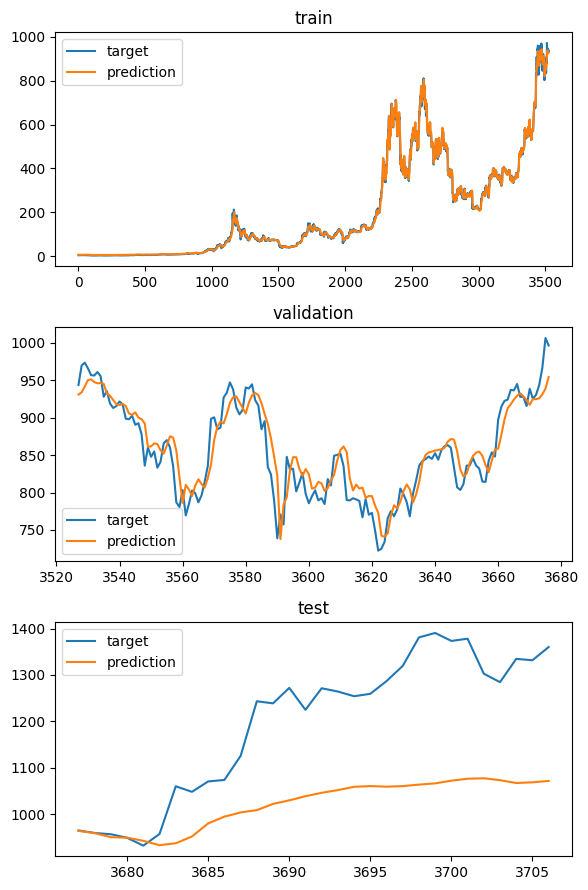

In [17]:
#마찬가지로 동일. 주석 pass

if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 5,
    "early_stop_delta": 0.01,
    }  

  args = SimpleNamespace(**args)
  main(args)

문제 2
------
wandb url #3임.
Regression 최적의 하이퍼 파라미터 값 찾기
https://wandb.ai/ajhajh503-korea-university-of-technology-and-education/g_lstm_regression_btc_krw?nw=nwuserajhajh503


1. epoch 50, early_stop_patience 15로 변경
==> epoch 32에서  early_stop Training loss 0.01322, Validation loss	0.1284
==> 오버피팅이 심각하다고 판단. representation을 키우는 방향으로 모델을 키우자.


2. hidden_size를 128 => 256으로 변경
==> epoch 42에서 early stop. Training loss 0.0159, Validation loss	0.24071
==> validation이 더 내려감.?

3. hidden_size를 256 => 512으로 변경
==> Epoch 31에서 early stop.Training loss 0.01975, Validation loss	0.05356
==> 극적인 성능 향상이 있었음.

4. hidden size를 키웠더니 성능이 향상함 => 512 => 1024로 변경
==>epoch 31 Training loss 0.01659, Validation loss	0.25165
==>train은 최저점이지만 val은 떨어진 것을 볼 수 있음. 오버 피팅이 발생해 오히러 모델 성능이 안 좋아짐. => hidden size는 512로 고정하는 걸로

5. hidden layer를 2 => 3으로 변경
==> Epoch	22 Training loss	0.03383 Validation loss	0.17069
==> 성능이 train, val 둘다 떨어짐.

6. hidden layer 3 => 5으로 변경
==> Epoch	24 Training loss	0.02378 Validation loss	0.06915
==> 성능이 2보단 하락함. layer 2으로 고정

7. weight decay => 0.0001 => 0.001로 변경
==> Epoch	24 Training loss	0.02289 Validation loss	0.07986
==> 성능이 조금 더 안좋아짐

8. weight decay => 0.001 => 0.0005로 변경
==> 47 Training loss	0.0175Validation loss	0.08042
==> 역시 성능이 더 안 좋아짐. decay를 더 키우면 성능이 하락하는 것 같음.

9. weight decay 를 0.00005로 축소
==> Epoch	24 Training loss	0.01412 Validation loss	0.07921
==> delta 값 0.005로 줄인 후, epoch 150으로 변경해도 early_stop에 걸려 성능 하락
weight decay는 기본 0.0001 사용하기로 함

10. lr => 0.001에서 0.01
==> 40Training loss	0.08915 Validation loss	0.54673
==> 성능이 처참해짐

11. lr => 0.0005로 기존의 반 사용
==> 42Training loss	0.01419 Validation loss	0.05613
==> train 성능은 최고, val은 2번째로 좋은 성능
lr을 감소하니 비슷하게 좋은 성능이 출력. 다음은 더 줄여보는 방향으로

12. lr = 0.0001
==> 65 Training loss	0.01263 Validation loss	0.05614
==> val 변화가 거의 없음. lr가 너무 작은 것 같음

13. lr = 0.0008
==> 33 Training loss	0.01616 Validation loss	0.04952
==> train, val 둘다 최고의 성능 lr은 0.0008 사용

14. early_stop_patience: 20, early_stop_delta: 0.0001
==> 67Training loss	0.01423 Validation loss	0.04979
==> train은 감소 했지만 val은 조금 증가함

15. dropout rate 0.5 => 0.3, 0.1
==> 63 Training loss	0.02253 Validation loss	0.10128
==> 성능이 하락함. 아마 dropout이 lstm과 잘 안맞는 것 같음.

16. dropout rate 0.7
==> 37 Training loss	0.0272Validation loss	0.255
==> 성능이 감소함.

17. dropout rate = 0. 사용을 안하면
==> 46 Training loss	0.02006 Validation loss	0.10428
==> 확실히 dropout을 사용하는 것이 쓰지 않을 때보다 성능이 좋음.

최종 하이퍼 파라미터:
    "batch_size": 32,
    "epochs": 200,
    "learning_rate": 0.0008,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001,
    "dropout_problity : 0.5"
    
아래는 사용한 모델과 predit_all 함수 수행 결과임.

In [16]:
# 위의 get model과 파라미터 값 이외에 동일.
# 주석은 변경한 파라미터만 작성

def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()
      # hiddensize 512, layer 그대로, 
      self.lstm = nn.LSTM(input_size=n_input, hidden_size=512, num_layers=2, batch_first=True)
      
      #input features 512로 변경
      self.fcn = nn.Linear(in_features=512, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "g_lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
  #parser = get_parser()
  #args = parser.parse_args()
    
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 200, # epoch 200으로
    "learning_rate": 0.0008, # 최적의 lr
    "weight_decay": 0.0001, #최적의 decay
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001, # delta 값 변경
    }  

  args = SimpleNamespace(**args)
  main(args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/work/.netrc
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


namespace(wandb=True, batch_size=32, epochs=200, learning_rate=0.0008, weight_decay=0.0001, validation_intervals=1, early_stop_patience=20, early_stop_delta=0.0001)
{'epochs': 200, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0008, 'early_stop_patience': 20, 'early_stop_delta': 0.0001, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.40348, V_loss: 0.20689, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.001
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_2024-12-08_15-17-22.pt
[Epoch   2] T_loss: 0.04816, V_loss: 0.15380, V_loss decreased (0.20689 --> 0.15380). Saving model... | T_time: 00:00:01, T_speed: 0.005
[Epoch   3] T_loss: 0.02826, V_loss: 0.17612, Early stopping counter: 1 out of 20 | T_time: 00:00:02, T_speed: 0.045
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_2024-12-08_15-17-22.pt
[Epoch   4] T_loss: 0.03326, V_los

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▄▁▂▁▁▁▂▁▁█▁▂▁▁▁▂▁▂▁▁▄▁▁
Validation loss,█▅▆▃▄▂▂▂▂▂▂▂▄▃▁▂▇▂▃▃▃▁▁▁▂▁▁▂▂▃▂▁█▁▂▃▁▃▂▃
Epoch,44
Training loss,0.0168
Training speed (epochs/sec.),0.05165
Validation loss,0.09516


In [17]:
#전부 동일. 주석 pass

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

if __name__ == "__main__":
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))
    
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "h_lstm_regression_btc_krw"

  tags=list(["lstm", "regression", "btc_krw"])
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=tags,
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "g_lstm_regression_btc_krw"
    
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )

  if not os.path.exists(latest_file_path):
    print(f"File not found: {latest_file_path}")
    print("Please check if the model file exists in the specified path.")
    return

  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

0 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0])
1 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 0])
2 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1])
3 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0])
4 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0])
5 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0])
6 - torch.Size([32, 21, 5]): torch.Size(

wandb: Currently logged in as: ajhajh503 (ajhajh503-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


MODEL FILE: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,066.64 <--> 1,243.20 (Loss:        176.55)
 1: 1,035.18 <--> 1,073.52 (Loss:         38.34)
 2: 947.82 <--> 1,059.85 (Loss:        112.04)
 3: 942.27 <--> 931.83 (Loss:         10.43)
 4: 1,208.21 <--> 1,378.05 (Loss:        169.84)
 5: 1,183.33 <--> 1,331.62 (Loss:        148.28)
 6: 1,159.71 <--> 1,254.02 (Loss:         94.30)
 7: 1,206.94 <--> 1,302.60 (Loss:         95.66)
 8: 956.02 <--> 956.43 (Loss:          0.41)
 9: 1,116.79 <--> 1,238.69 (Loss:        121.90)
10: 980.36 <--> 964.63 (Loss:         15.73)
11: 1,006.87 <--> 1,047.88 (Loss:         41.00)
12: 1,134.74 <--> 1,272.01 (Loss:        137.27)
13: 1,153.28 <--> 1,264.13 (Loss:        110.85)
14: 1,038.77 <--> 1,125.35 (Loss:         86.58)
15: 1,173.65 <--> 1,334.58 (Loss:        160.93)
16: 1,157.33 <--> 1,286.65 (Loss:        129.32)
17: 1,175.16 <--> 1,380.87 (Loss:        205.71)
18: 1,164.36 <--> 1,319.4

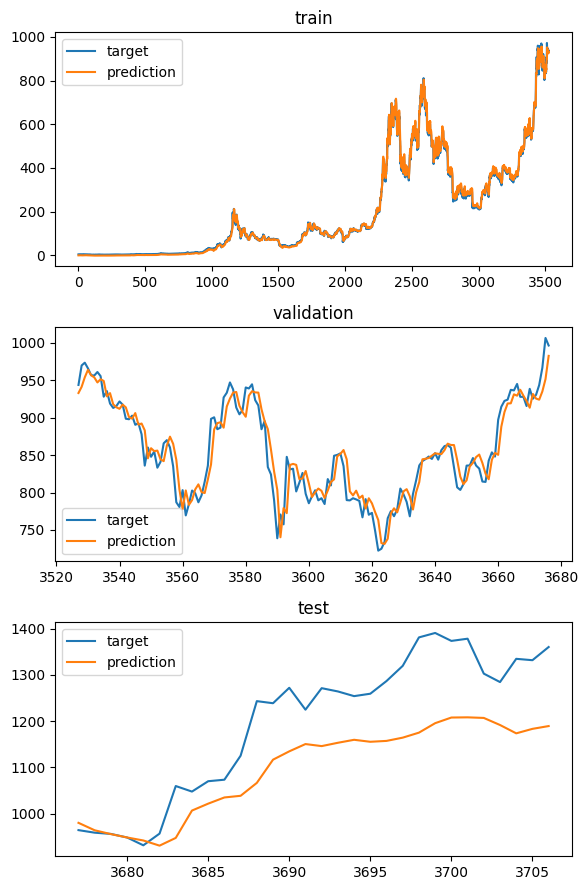

In [18]:
# 최적의 파라미터 값으로 args 설정
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 200,
    "learning_rate": 0.0008,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001,
    }  

  args = SimpleNamespace(**args)
  main(args)

문제 3
------
wandb url #5임.
https://wandb.ai/ajhajh503-korea-university-of-technology-and-education/h_lstm_regression_btc_krw?nw=nwuserajhajh503

next_ open 추가시 성능만 보면
Training loss	0.01776
Training speed (epochs/sec.)	0.49171
Validation loss	0.05189
==>
Training loss	0.00222
Training speed (epochs/sec.)	0.086
Validation loss	0.00162
매우 큰 폭으로 모델의 성능 향상이 있는 것을 볼 수 있음.

In [19]:
#next open 추가
def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
    df = pd.read_csv(btc_krw_path)

    # 'Next_Open' 열 추가
    df['Next_Open'] = df['Open'].shift(-1)  # 'Open' 열을 한 칸 위로 이동
    df = df[:-1]  # 마지막 행 제거 => NaN 발생

    row_size = len(df)
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)

    # 데이터 전처리 함수 정의
    def process_data(start_idx, size):
        X_list = []
        y_list = []
        date_list_out = []

        for idx in range(start_idx, start_idx + size):
            # 시퀀스 데이터와 Next_Open 병합
            sequence_data = df.iloc[idx: idx + sequence_size].values  # 시퀀스 데이터
            next_open = df.iloc[idx + sequence_size]['Next_Open']  # 다음 Open 값

            # 'Next_Open' 값을 시퀀스 데이터의 추가 ==> feature로 포함
            sequence_with_next_open = np.hstack([sequence_data, [[next_open]] * sequence_size])

            X_list.append(sequence_with_next_open)  # 리스트에 numpy 배열 추가
            if is_regression:
                # 회귀 문제: 타겟 값을 정규화하여 추가
                y_list.append(df.iloc[idx + sequence_size][target_column] / y_normalizer)
            else:
                # 분류 문제: 타겟 클래스(상승/하락) 추가
                y_list.append(
                    1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
                )
            date_list_out.append(date_list[idx + sequence_size])

        # numpy 배열로 변환
        X_array = np.array(X_list, dtype=np.float32)
        y_array = np.array(y_list, dtype=np.float32 if is_regression else np.int64)

        # numpy 배열을 PyTorch 텐서로 변환
        X = torch.tensor(X_array)
        y = torch.tensor(y_array)

        return X, y, date_list_out

    # 학습, val, 테스트 데이터셋 생성
    X_train, y_train, train_dates = process_data(0, train_size)
    X_validation, y_validation, validation_dates = process_data(train_size, validation_size)
    X_test, y_test, test_dates = process_data(train_size + validation_size, test_size)

    # 학습 데이터 정규화 (평균 및 표준편차 계산)
    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    # 정규화 적용
    X_train = (X_train - m) / s
    X_validation = (X_validation - m) / s
    X_test = (X_test - m) / s

    # 반환값 구성
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train, y_validation, y_test,
            train_dates, validation_dates, test_dates
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train, y_validation, y_test,
            train_dates, validation_dates, test_dates
        )



if __name__ == "__main__":
    # regression true
    is_regression = True

    # 데이터 로드 및 전처리
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
        sequence_size=21, validation_size=150, test_size=30,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # 학습 데이터셋 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    # 데이터 로더 구성
    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
    )

    # 데이터 로더 확인
    for idx, batch in enumerate(train_data_loader):
        input, target = batch
        print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))


0 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1.2317, 3.2017, 3.8542, 1.0230, 3.9202, 0.0485, 0.7320, 6.0932, 4.8462,
        5.7780, 4.7429, 0.0250, 6.4972, 9.3644, 0.0458, 9.2677, 6.7092, 0.0668,
        0.1439, 1.0286, 0.9524, 0.3665, 3.5506, 0.0491, 0.9617, 5.2903, 0.0298,
        0.0335, 5.5311, 2.8137, 1.1681, 1.2461])
1 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1.6874, 5.6973, 3.9167, 1.0884, 2.5148, 0.0501, 3.9832, 0.9921, 0.8912,
        2.7907, 4.3103, 3.5246, 0.0328, 5.0357, 0.0624, 0.4550, 0.0256, 0.2786,
        1.1622, 0.1379, 0.8449, 0.7398, 0.1144, 0.0662, 0.0321, 0.3575, 2.7297,
        0.0811, 0.7020, 5.1956, 0.0276, 6.0327])
2 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0.7292, 2.2429, 2.2281, 0.0236, 9.5541, 0.0243, 0.0420, 0.6497, 7.1468,
        2.1467, 0.7347, 1.3949, 6.2275, 0.0271, 0.9497, 1.2063, 0.0789, 0.7657,
        0.0465, 0.0771, 0.4785, 5.7128, 0.0523, 0.0388, 0.0751, 0.3877, 0.7467,
        1.5615, 0.0494, 0.8744, 1.3497, 2

In [20]:
#최적의 모델을 가져옴.
# input features가 변경된거 외에 전부 동일함.

def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=512, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=512, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=7, n_output=1)

  return my_model

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "g_lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 200,
    "learning_rate": 0.0008,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001,
    }  

  args = SimpleNamespace(**args)
  main(args)

namespace(wandb=True, batch_size=32, epochs=200, learning_rate=0.0008, weight_decay=0.0001, validation_intervals=1, early_stop_patience=20, early_stop_delta=0.0001)
{'epochs': 200, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0008, 'early_stop_patience': 20, 'early_stop_delta': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.62183, V_loss: 0.13054, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_2024-12-08_15-19-37.pt
[Epoch   2] T_loss: 0.02236, V_loss: 0.07928, V_loss decreased (0.13054 --> 0.07928). Saving model... | T_time: 00:00:01, T_speed: 0.008
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_2024-12-08_15-19-37.pt
[Epoch   3] T_loss: 0.01210, V_loss: 0.02867, V_loss decreased (0.07928 --> 0.02867). Saving model... | T_time: 00:00:01, T_speed: 0.003
[Epoch   4] T_loss: 0.01913, V_loss: 0

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
Validation loss,▂▂▁▁▂▁▁▁▁▁▃▁▁▁▁▆▁▁▁▆▁▁▁▁▆▁▁▁▁▁▂▁▁█▁
Epoch,35
Training loss,0.01911
Training speed (epochs/sec.),0.14892
Validation loss,0.00654


In [21]:
#test 함수 그대로 추가. 변경점 x 

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

if __name__ == "__main__":
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))
    
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "h_lstm_regression_btc_krw"

  tags=list(["lstm", "regression", "btc_krw"])
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=tags,
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "g_lstm_regression_btc_krw"
    
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )

  if not os.path.exists(latest_file_path):
    print(f"File not found: {latest_file_path}")
    print("Please check if the model file exists in the specified path.")
    return

  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

0 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1])
1 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0])
2 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0])
3 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0])
4 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0])
5 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0])
6 - torch.Size([32, 21, 7]): torch.Size(

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


MODEL FILE: /home/work/DL/homework4/checkpoints/g_lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,094.06 <--> 1,378.05 (Loss:        283.99)
 1: 1,081.92 <--> 1,284.38 (Loss:        202.47)
 2: 1,090.31 <--> 1,380.87 (Loss:        290.56)
 3: 960.27 <--> 964.63 (Loss:          4.36)
 4: 952.43 <--> 956.43 (Loss:          4.00)
 5: 1,074.06 <--> 1,254.02 (Loss:        179.96)
 6: 1,070.21 <--> 1,272.01 (Loss:        201.80)
 7: 999.11 <--> 1,047.88 (Loss:         48.77)
 8: 1,084.99 <--> 1,331.62 (Loss:        246.63)
 9: 1,002.30 <--> 1,059.85 (Loss:         57.55)
10: 1,064.19 <--> 1,224.73 (Loss:        160.54)
11: 976.28 <--> 996.63 (Loss:         20.35)
12: 1,092.02 <--> 1,390.43 (Loss:        298.41)
13: 1,062.45 <--> 1,243.20 (Loss:        180.75)
14: 1,072.98 <--> 1,264.13 (Loss:        191.15)
15: 1,012.78 <--> 1,070.26 (Loss:         57.48)
16: 1,078.74 <--> 1,286.65 (Loss:        207.90)
17: 1,072.36 <--> 1,271.21 (Loss:        198.86)
18: 1,084.80 <--> 1,334.5

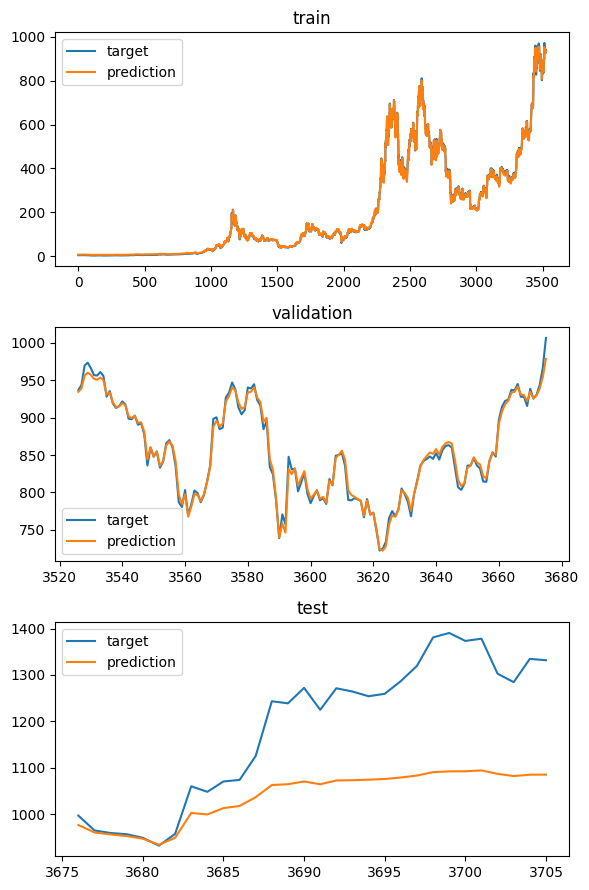

In [22]:
if __name__ == "__main__":

  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 200,
    "learning_rate": 0.0008,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001,
    }  

  args = SimpleNamespace(**args)
  main(args)

i_crypto_currency_classification_train_lstm
------

In [54]:
# next open 다시 삭제
# 나머지 동일. 주석 pass
def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=False
):
  btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
  df = pd.read_csv(btc_krw_path)
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']

  df = df.drop(columns=['Date'])

  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )


if __name__ == "__main__":
  is_regression = False

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10,
    target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))


0 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 0])
1 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1])
2 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1])
3 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1])
4 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0])
5 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1])
6 - torch.Size([32, 10, 5]): torch.Size(

In [55]:
class ClassificationTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
        run_time_str, wandb, device, checkpoint_file_path
    ):
        # 클래스 초기화: 모델, 데이터 로더, 최적화 등 초기화
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        # 손실 함수로 교차 엔트로피 사용
        self.loss_fn = nn.CrossEntropyLoss()

    def do_train(self):
        # 모델을 학습 모드로 설정
        self.model.train()

        loss_train = 0.0
        num_corrects_train = 0
        num_trained_samples = 0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            # 데이터 변환(옵션)
            if self.transforms:
                input_train = self.transforms(input_train)

            # 모델 출력 계산
            output_train = self.model(input_train)
            loss = self.loss_fn(output_train, target_train)  # 손실 계산
            loss_train += loss.item()

            # 예측값 계산
            predicted_train = torch.argmax(output_train, dim=-1)
            num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

            num_trained_samples += len(input_train)
            num_trains += 1

            # 역전파 및 가중치 업데이트
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains
        train_accuracy = 100.0 * num_corrects_train / num_trained_samples

        return train_loss, train_accuracy

    def do_validation(self):
        # 모델을 평가 모드로 설정
        self.model.eval()

        loss_validation = 0.0
        num_corrects_validation = 0
        num_validated_samples = 0
        num_validations = 0

        with torch.no_grad():  # grad 비활성화
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                # 데이터 변환
                if self.transforms:
                    input_validation = self.transforms(input_validation)

                # 모델 출력 계산
                output_validation = self.model(input_validation)
                loss_validation += self.loss_fn(output_validation, target_validation).item()

                # 예측값 계산
                predicted_validation = torch.argmax(output_validation, dim=1)
                num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

                num_validated_samples += len(input_validation)
                num_validations += 1

        validation_loss = loss_validation / num_validations
        validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

        return validation_loss, validation_accuracy

    def train_loop(self):
        # 조기 종료 설정
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            # 학습 및 검증 단계 수행
            train_loss, train_accuracy = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss, validation_accuracy = self.do_validation()

                # 진행 시간 및 속도 계산
                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

                # 조기 종료 조건 확인 및 메시지 출력
                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"T_accuracy: {train_accuracy:6.4f} | "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"V_accuracy: {validation_accuracy:6.4f} | "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )

                # wandb에 로그 저장
                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Training accuracy (%)": train_accuracy,
                    "Validation loss": validation_loss,
                    "Validation accuracy (%)": validation_accuracy,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })

                # 조기 종료 조건 만족 시 중단
                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


In [56]:
#기본 파라미터(hidden size 256 etc)으로 시작
# output이 2개임 => 1 or 0
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

In [57]:
def main(args):
    # 실행 시각을 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 설정 값을 딕셔너리로 정의
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    # wandb 프로젝트 설정
    project_name = "i_lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 설정값 출력
    print(args)
    print(wandb.config)

    # 데이터 로더 생성 이때 regression false!!
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)

    # 학습 디바이스 설정 (GPU가 있으면 GPU, 없으면 CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성
    model = get_model()
    model.to(device)

    # 최적화 Adam
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

    # 분류 트레이너 초기화 및 학습 루프 실행
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    # W&B 종료
    wandb.finish()


In [58]:
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 5,
    "early_stop_delta": 0.01,
    }  

  args = SimpleNamespace(**args)
  main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


namespace(wandb=True, batch_size=32, epochs=100, learning_rate=0.001, weight_decay=0.0001, validation_intervals=1, early_stop_patience=5, early_stop_delta=0.01)
{'epochs': 100, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 5, 'early_stop_delta': 0.01, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69218, T_accuracy: 52.3107 | V_loss: 0.69465, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69141, T_accuracy: 52.6510 | V_loss: 0.69233, V_accuracy: 52.6667 | Early stopping counter: 1 out of 5 | T_time: 00:00:01, T_speed: 2.000
[Epoch   3] T_loss: 0.69147, T_accuracy: 52.8778 | V_loss: 0.69263, V_accuracy: 52.6667 | Early stopping counter: 2 out of 5 | T_time: 00:00:02, T_speed: 1.500
[Epoch   4] T_loss: 0.69135, T_accuracy: 53.1613 | V_loss: 0.69219, V_accuracy: 52.6667 | Early stopping counter: 3 out of 5 | T_time: 00:00:02, T_speed: 2.000
[Epoch   5] T_loss: 

Epoch,▁▂▄▅▇█
Training accuracy (%),▁▃▅▆▄█
Training loss,█▂▂▁▃▃
Training speed (epochs/sec.),▁█▆█▇▆
Validation accuracy (%),▁▅▅▅█▅
Validation loss,█▁▂▁▂▂
Epoch,6
Training accuracy (%),53.4165
Training loss,0.69163
Training speed (epochs/sec.),1.5
Validation accuracy (%),52.66667


문제 1 wandb url #2임

https://wandb.ai/ajhajh503-korea-university-of-technology-and-education/h_lstm_regression_btc_krw?nw=nwuserajhajh503

j_crypto_currency_classification_test_lstm
-----

In [59]:
def test(test_model):
  # 테스트 데이터 로더 생성 분류 문제용
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

In [78]:
# 파일 저장하는 이름 빼고 전부 동일. 주석 pass

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "j_lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()
  project_name = "i_lstm_classification_btc_krw"

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

In [79]:
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 10,
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 5,
    "early_stop_delta": 0.01,
    }  

  args = SimpleNamespace(**args)
  main(args)

MODEL FILE: /home/work/DL/homework4/checkpoints/i_lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 53.333%
 0:   1.00 <-->   0.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   0.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   1.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   1.00 <-->   0.00
16:   1.00 <-->   0.00
17:   1.00 <-->   0.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   0.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   1.00 <-->   0.00
24:   1.00 <-->   1.00
25:   1.00 <-->   1.00
26:   1.00 <-->   1.00
27:   1.00 <-->   1.00
28:   1.00 <-->   0.00
29:   1.00 <-->   1.00


문제 2
-------
최적의 모델 찾기
wandb url #4
https://wandb.ai/ajhajh503-korea-university-of-technology-and-education/i_lstm_classification_btc_krw?nw=nwuserajhajh503


1. regression 때 찾은 최적 값으로 시작
Epoch	23
Training accuracy (%)	53.24639
Training loss	0.69077
Training speed (epochs/sec.)	1.64286
Validation accuracy (%)	48
Validation loss	0.69357

2. hidden size 256
Epoch	23
Training accuracy (%)	53.18968
Training loss	0.69065
Training speed (epochs/sec.)	1.76923
Validation accuracy (%)	47.33333
Validation loss	0.6944
val의 acc가 감소함

3. hidden size 1024
Epoch	38
Training accuracy (%)	52.76439
Training loss	0.69126
Training speed (epochs/sec.)	0.95
Validation accuracy (%)	56
Validation loss	0.69285
train은 acc가 감소했지만 val은 상승

4. size 2048
Epoch	31
Training accuracy (%)	51.23334
Training loss	0.6979
Training speed (epochs/sec.)	0.31633
Validation accuracy (%)	52.66667
Validation loss	0.69295
val acc 감소 hidden size는 1024로

6. later 2 => 3
Epoch	29
Training accuracy (%)	52.05557
Training loss	0.69401
Training speed (epochs/sec.)	0.64444
Validation accuracy (%)	52.66667
Validation loss	0.69174
acc 감소함

7. layer 3 => 5
Epoch	44
Training accuracy (%)	52.96286
Training loss	0.6916
Training speed (epochs/sec.)	0.37931
Validation accuracy (%)	52.66667
Validation loss	0.69131
acc 감소

8. layer 5 => 1
Epoch	36
Training accuracy (%)	52.93451
Training loss	0.69106
Training speed (epochs/sec.)	1.8
Validation accuracy (%)	47.33333
Validation loss	0.69549
layer 2로 하는 것이 제일 acc가 높음.

9. weight decay 0.0001 => 0.001
Epoch	33
Training accuracy (%)	53.16133
Training loss	0.69149
Training speed (epochs/sec.)	0.97059
Validation accuracy (%)	48.66667
Validation loss	0.69338
acc 감소

10. 0.001 => 0.0005
Epoch	41
Training accuracy (%)	52.8778
Training loss	0.69124
Training speed (epochs/sec.)	0.93182
Validation accuracy (%)	52.66667
Validation loss	0.69169
56%에 비해 감소함.
decay는 그대로 0.0001 사용

11. lr 0.0008 => 0.001
Epoch	45
Training accuracy (%)	52.14063
Training loss	0.69415
Training speed (epochs/sec.)	0.95745
Validation accuracy (%)	52.66667
Validation loss	0.69193

12. 0.001 => 0.0001
Epoch	39
Training accuracy (%)	53.50156
Training loss	0.69114
Training speed (epochs/sec.)	1.34483
Validation accuracy (%)	49.33333
Validation loss	0.69398
acc가 오히러 감소

12. 0.0001 => 0.0005
Epoch	48
Training accuracy (%)	53.27474
Training loss	0.69064
Training speed (epochs/sec.)	1.33333
Validation accuracy (%)	47.33333
Validation loss	0.6944
기존의 0.0008 사용

12. dropout rate 0.5 => 0.3
Epoch	22
Training accuracy (%)	52.50921
Training loss	0.69062
Training speed (epochs/sec.)	0.95652
Validation accuracy (%)	50.66667
Validation loss	0.69301
=> 0.5 사용

13. batch size 32 => 64
Epoch	62
Training accuracy (%)	52.96286
Training loss	0.69173
Training speed (epochs/sec.)	1.31915
Validation accuracy (%)	52.66667
Validation loss	0.69318
성능은 오르지 않았지만 128로 변경해 볼만함

14. batch size 128
Epoch	22
Training accuracy (%)	52.76439
Training loss	0.69097
Training speed (epochs/sec.)	1.57143
Validation accuracy (%)	47.33333
Validation loss	0.69481
validation을 줄이기가 쉽지 않음


최적의 모델
    "wandb": True,
    "batch_size": 32,
    "epochs": 200, # epoch 200으로
    "learning_rate": 0.0001, # 최적의 lr
    "weight_decay": 0.0001, #최적의 decay
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001, # delta 값 변경
    "dropout_rate" = 0.5
    hidden_size = 1024
    layer = 2

In [95]:
#위에서 regression 문제에서 구한 파라미터로 시작
#wandb.login()

def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=1024, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=1024, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

def main(args):
    # 실행 시각을 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 설정 값을 딕셔너리로 정의
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    # wandb 프로젝트 설정
    project_name = "i_lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 설정값 출력
    print(args)
    print(wandb.config)

    # 데이터 로더 생성 이때 regression false!!
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)

    # 학습 디바이스 설정 (GPU가 있으면 GPU, 없으면 CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성
    model = get_model()
    model.to(device)

    # 최적화 Adam
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

    # 분류 트레이너 초기화 및 학습 루프 실행
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 200, # epoch 200으로
    "learning_rate": 0.0008, # 최적의 lr
    "weight_decay": 0.0001, #최적의 decay
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001, # delta 값 변경
    }  

  args = SimpleNamespace(**args)
  main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


namespace(wandb=True, batch_size=32, epochs=200, learning_rate=0.0008, weight_decay=0.0001, validation_intervals=1, early_stop_patience=20, early_stop_delta=0.0)
{'epochs': 200, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0008, 'early_stop_patience': 20, 'early_stop_delta': 0.0, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69224, T_accuracy: 52.5092 | V_loss: 0.69383, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:01, T_speed: 1.000
[Epoch   2] T_loss: 0.69095, T_accuracy: 52.7927 | V_loss: 1.34410, V_accuracy: 47.3333 | Early stopping counter: 1 out of 20 | T_time: 00:00:02, T_speed: 1.000
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/i_lstm_classification_btc_krw_checkpoint_2024-12-08_16-35-58.pt
[Epoch   3] T_loss: 0.69659, T_accuracy: 52.5659 | V_loss: 0.69126, V_accuracy: 52.6667 | V_loss decreased (0.69383 --> 0.69126). Saving model... | T_time: 00:00:03, T_speed: 1.000
[Epoch   4] T_loss: 0.69089,

Epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
Training accuracy (%),▂▄▂▇▃▆▄█▃▃▆▁▇█▇▄▆▆▇▇▅▁▆
Training loss,▃▁█▁▂▂▂▁▂▂▁▂▁▁▁▂▂▁▁▂▂▂▂
Training speed (epochs/sec.),████████████████▁▁▂▂▂▃▃
Validation accuracy (%),▁▁▇▇▇█▇▁▇▇▁▇▂▇▁▇▇▇▁▇▇▇▇
Validation loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,23
Training accuracy (%),52.96286
Training loss,0.69114
Training speed (epochs/sec.),0.95833
Validation accuracy (%),53.33333


문제 3
--------
feature 추가
wandb url #6
https://wandb.ai/ajhajh503-korea-university-of-technology-and-education/i_lstm_classification_btc_krw?nw=nwuserajhajh503

학습 중간에 validaion acc가 97.33%까지 증가.


In [100]:
#next open 추가
def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=False
):
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
    df = pd.read_csv(btc_krw_path)

    # 'Next_Open' 열 추가
    df['Next_Open'] = df['Open'].shift(-1)  # 'Open' 열을 한 칸 위로 이동
    df = df[:-1]  # 마지막 행 제거 => NaN 발생

    row_size = len(df)
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)

    # 데이터 전처리 함수 정의
    def process_data(start_idx, size):
        X_list = []
        y_list = []
        date_list_out = []

        for idx in range(start_idx, start_idx + size):
            # 시퀀스 데이터와 Next_Open 병합
            sequence_data = df.iloc[idx: idx + sequence_size].values  # 시퀀스 데이터
            next_open = df.iloc[idx + sequence_size]['Next_Open']  # 다음 Open 값

            # 'Next_Open' 값을 시퀀스 데이터의 추가 ==> feature로 포함
            sequence_with_next_open = np.hstack([sequence_data, [[next_open]] * sequence_size])

            X_list.append(sequence_with_next_open)  # 리스트에 numpy 배열 추가
            if is_regression:
                # 회귀 문제: 타겟 값을 정규화하여 추가
                y_list.append(df.iloc[idx + sequence_size][target_column] / y_normalizer)
            else:
                # 분류 문제: 타겟 클래스(상승/하락) 추가
                y_list.append(
                    1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
                )
            date_list_out.append(date_list[idx + sequence_size])

        # numpy 배열로 변환
        X_array = np.array(X_list, dtype=np.float32)
        y_array = np.array(y_list, dtype=np.float32 if is_regression else np.int64)

        # numpy 배열을 PyTorch 텐서로 변환
        X = torch.tensor(X_array)
        y = torch.tensor(y_array)

        return X, y, date_list_out

    # 학습, val, 테스트 데이터셋 생성
    X_train, y_train, train_dates = process_data(0, train_size)
    X_validation, y_validation, validation_dates = process_data(train_size, validation_size)
    X_test, y_test, test_dates = process_data(train_size + validation_size, test_size)

    # 학습 데이터 정규화 (평균 및 표준편차 계산)
    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    # 정규화 적용
    X_train = (X_train - m) / s
    X_validation = (X_validation - m) / s
    X_test = (X_test - m) / s

    # 반환값 구성
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train, y_validation, y_test,
            train_dates, validation_dates, test_dates
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train, y_validation, y_test,
            train_dates, validation_dates, test_dates
        )



if __name__ == "__main__":
    # regression true
    is_regression = False

    # 데이터 로드 및 전처리
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
        sequence_size=21, validation_size=150, test_size=30,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # 학습 데이터셋 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    # 데이터 로더 구성
    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
    )

    # 데이터 로더 확인
    for idx, batch in enumerate(train_data_loader):
        input, target = batch
        print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))


0 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0])
1 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0])
2 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1])
3 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1])
4 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 1])
5 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0])
6 - torch.Size([32, 21, 7]): torch.Size(

In [105]:
def main(args):
    # 실행 시각을 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 설정 값을 딕셔너리로 정의
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    # wandb 프로젝트 설정
    project_name = "i_lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 설정값 출력
    print(args)
    print(wandb.config)

    # 데이터 로더 생성 이때 regression false!!
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)

    # 학습 디바이스 설정 (GPU가 있으면 GPU, 없으면 CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성
    model = get_model()
    model.to(device)

    # 최적화 Adam
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

    # 분류 트레이너 초기화 및 학습 루프 실행
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

In [104]:
wandb.login()

if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 200, # epoch 200으로
    "learning_rate": 0.0008, # 최적의 lr
    "weight_decay": 0.0001, #최적의 decay
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001, # delta 값 변경
    }  

  args = SimpleNamespace(**args)
  main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


namespace(wandb=True, batch_size=32, epochs=200, learning_rate=0.0008, weight_decay=0.0001, validation_intervals=1, early_stop_patience=20, early_stop_delta=0.0001)
{'epochs': 200, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0008, 'early_stop_patience': 20, 'early_stop_delta': 0.0001, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69380, T_accuracy: 53.0346 | V_loss: 0.69264, V_accuracy: 53.3333 | Early stopping is stated! | T_time: 00:00:01, T_speed: 1.000
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/i_lstm_classification_btc_krw_checkpoint_2024-12-08_16-47-34.pt
[Epoch   2] T_loss: 0.69166, T_accuracy: 53.0062 | V_loss: 0.69071, V_accuracy: 53.3333 | V_loss decreased (0.69264 --> 0.69071). Saving model... | T_time: 00:00:02, T_speed: 1.000
[Epoch   3] T_loss: 0.69206, T_accuracy: 52.6659 | V_loss: 0.69185, V_accuracy: 56.0000 | Early stopping counter: 1 out of 20 | T_time: 00:00:03, T_speed: 1.000
Saving model checkpoin

[Epoch  39] T_loss: 0.68507, T_accuracy: 54.9348 | V_loss: 0.62123, V_accuracy: 72.0000 | V_loss decreased (0.65060 --> 0.62123). Saving model... | T_time: 00:00:44, T_speed: 0.886
[Epoch  40] T_loss: 0.68279, T_accuracy: 56.8917 | V_loss: 0.67341, V_accuracy: 56.0000 | Early stopping counter: 1 out of 20 | T_time: 00:00:45, T_speed: 0.889
[Epoch  41] T_loss: 0.67396, T_accuracy: 57.9977 | V_loss: 0.79588, V_accuracy: 46.6667 | Early stopping counter: 2 out of 20 | T_time: 00:00:46, T_speed: 0.891
Saving model checkpoint to: /home/work/DL/homework4/checkpoints/i_lstm_classification_btc_krw_checkpoint_2024-12-08_16-47-34.pt
[Epoch  42] T_loss: 0.66904, T_accuracy: 59.4725 | V_loss: 0.59474, V_accuracy: 72.0000 | V_loss decreased (0.62123 --> 0.59474). Saving model... | T_time: 00:00:47, T_speed: 0.894
[Epoch  43] T_loss: 0.67227, T_accuracy: 57.7992 | V_loss: 0.77062, V_accuracy: 48.0000 | Early stopping counter: 1 out of 20 | T_time: 00:00:49, T_speed: 0.878
[Epoch  44] T_loss: 0.65609

[Epoch  79] T_loss: 0.70114, T_accuracy: 52.6375 | V_loss: 0.71563, V_accuracy: 46.6667 | Early stopping counter: 6 out of 20 | T_time: 00:01:30, T_speed: 0.878
[Epoch  80] T_loss: 0.69981, T_accuracy: 51.0210 | V_loss: 0.69497, V_accuracy: 50.0000 | Early stopping counter: 7 out of 20 | T_time: 00:01:31, T_speed: 0.879
[Epoch  81] T_loss: 0.69907, T_accuracy: 51.8434 | V_loss: 0.75131, V_accuracy: 48.6667 | Early stopping counter: 8 out of 20 | T_time: 00:01:32, T_speed: 0.880
[Epoch  82] T_loss: 0.70395, T_accuracy: 52.2405 | V_loss: 0.69025, V_accuracy: 48.6667 | Early stopping counter: 9 out of 20 | T_time: 00:01:33, T_speed: 0.882
[Epoch  83] T_loss: 0.69843, T_accuracy: 52.1838 | V_loss: 0.70667, V_accuracy: 53.3333 | Early stopping counter: 10 out of 20 | T_time: 00:01:34, T_speed: 0.883
[Epoch  84] T_loss: 0.69867, T_accuracy: 51.6733 | V_loss: 0.82990, V_accuracy: 46.6667 | Early stopping counter: 11 out of 20 | T_time: 00:01:35, T_speed: 0.884
[Epoch  85] T_loss: 0.69897, T_a

Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▂▂▂▂▂▂▂▁▁▁▁▂▁▂▂▃▄▄▅▆▆▇▆▇▇█▇██▁▁▁▁▁▁
Training loss,▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▃▃▃▂▄▂▂▂▁▁▁▁▁▁▁█▄▄▄▄▄▄
Training speed (epochs/sec.),████▄▄▅▂▁▁▁▁▂▂▃▃▃▃▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃
Validation accuracy (%),▂▂▃▂▂▃▄▁▄▁▂▂▂▂▂▂▂▂▂▅▂▁▅▆▅▅▅▆▅█▇▇▄▇▁▁▁▂▂▁
Validation loss,▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▇▄█▃▃▃▂▂▃▂▁▃▂▁▂▅▅▆▅▅▅▅
Epoch,93
Training accuracy (%),52.52411
Training loss,0.6976
Training speed (epochs/sec.),0.89423
Validation accuracy (%),46.66667


In [106]:
# 파일 저장하는 이름 빼고 전부 동일. 주석 pass

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "j_lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()
  project_name = "i_lstm_classification_btc_krw"

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
    
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 200, # epoch 200으로
    "learning_rate": 0.0008, # 최적의 lr
    "weight_decay": 0.0001, #최적의 decay
    "validation_intervals": 1,
    "early_stop_patience": 20,
    "early_stop_delta": 0.0001, # delta 값 변경
    }  

  args = SimpleNamespace(**args)
  main(args)

MODEL FILE: /home/work/DL/homework4/checkpoints/i_lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 100.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   0.00
 6:   0.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   1.00 <-->   1.00
10:   0.00 <-->   0.00
11:   1.00 <-->   1.00
12:   1.00 <-->   1.00
13:   0.00 <-->   0.00
14:   0.00 <-->   0.00
15:   1.00 <-->   1.00
16:   0.00 <-->   0.00
17:   1.00 <-->   1.00
18:   0.00 <-->   0.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   0.00 <-->   0.00
24:   0.00 <-->   0.00
25:   0.00 <-->   0.00
26:   1.00 <-->   1.00
27:   1.00 <-->   1.00
28:   1.00 <-->   1.00
29:   1.00 <-->   1.00


기술적 사항/고찰
===
LSTM RNN 구조를 구현하여 시계열 데이터 분석 모델을 구축에 성공했습니다.
다중 계층num_layers=2과 은닉 상태 크기(hidden_size=256~1024)로 모델의 복잡도를 조정하였습니다.
Fully Connected Layer(FCN)를 통해 최종 출력 차원을 조정(1 OR 2)하고, 회귀 문제에 적합한 출력 OUTPUT SIZE 1과 분류 문제에 적합한 출력 OUTPUT SIZE 2를 생성하였습니다.
Adam 옵티마이저와 weight_decay=0.0001을 활용하여 오버피팅을 방지하는데 성공했습니다.
LR, weight_decay, sequence_size, hidden_size 등의 하이퍼파라미터를 실험적으로 조정해보았는데 쉽지 않았습니다.
wandb를 활용해 실험 데이터를 로깅하고 시각화하여, 여러 실험 간 성능 비교를 수행했고, 분석 했습니다.


숙제후기
---
이번 숙제를 통해 코인 시세를 LSTM 기반 RNN 모델을 구현하였습니다. LSTM 기반 RNN 모델을 설계하고 학습시키며 시계열 데이터 처리에서 LSTM의 강력함을 체감할 수 있었습니다. next open까지 넣게 되면, 매우 높은 정확도가 나오는 것이 신기했습니다.
데이터의 장기 의존성을 효과적으로 처리하는 과정에서 학습률(learning_rate)과 weight_decay 등 하이퍼파라미터의 중요성을 실감했고, 이를 조정하는게 쉽지 않은 길이라는 것을 깨달았습니다.
dropout rate라던가 이론적으로는 사용하면 성능이 확 좋아질 줄 알았지만 오히러 성능이 감소하기도 해서 이론과 실전의 차이를 깨닫고, 앞으로의 프로젝트에 큰 도움이 될 교훈을 얻을 수 있엇던 기회였습니다.